In [1]:
import datasets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

# Instruct Dataset Training and Validation Sets Distribution

In [2]:
dataset = datasets.load_from_disk('../../combining_instruct_datasets_with_non_disclosure_reqs/falcon_requirement_generation_dataset')

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['REQID_ex', 'completion', 'query', 'class', 'task', 'text', 'label'],
        num_rows: 132
    })
    test: Dataset({
        features: ['REQID_ex', 'completion', 'query', 'class', 'task', 'text', 'label'],
        num_rows: 34
    })
})

In [4]:
dataset_train = dataset['train']
dataset_test = dataset['test']

In [5]:
np.unique(dataset_train['class'], return_counts = True)

(array(['A', 'FT', 'HOW-TO-WRITE-REQUIRMENT-TASK-SWARD-BASED', 'L', 'LF',
        'MISSING-TASK-5-SHORTENED', 'MN', 'O', 'PE', 'PO', 'SC', 'SE',
        'US'], dtype='<U40'),
 array([ 8,  8, 40,  8,  8,  4,  8,  8,  8,  8,  8,  8,  8]))

In [6]:
# Renaming some columns

def rename_tasks(column):
    task_mapping = {'NF-TYPES-TASK-PROMISE': 'RE-types INST',
                    'NF-TYPES-TASK-PO': 'RE-types INST',
                    'MISSING-TASK-5-SHORTENED': 'Missing INST',
                    'HOW-TO-WRITE-REQUIRMENT-TASK-SWARD-BASED': 'How-to? INST'}
    tasks = column['task']
    if isinstance(tasks, str):
        tasks = task_mapping[tasks]
    
    if isinstance(tasks, list):
        renamed_list = []
        for task in tasks:
            renamed_list.append(task_mapping[task])
        tasks = renamed_list

    return {'renamed_tasks': tasks}

In [7]:
dataset_train = dataset_train.map(rename_tasks, batched = True)
dataset_test = dataset_test.map(rename_tasks, batched = True)

In [8]:
train_distro = np.unique(dataset_train['renamed_tasks'], return_counts = True)
test_distro = np.unique(dataset_test['renamed_tasks'], return_counts = True)

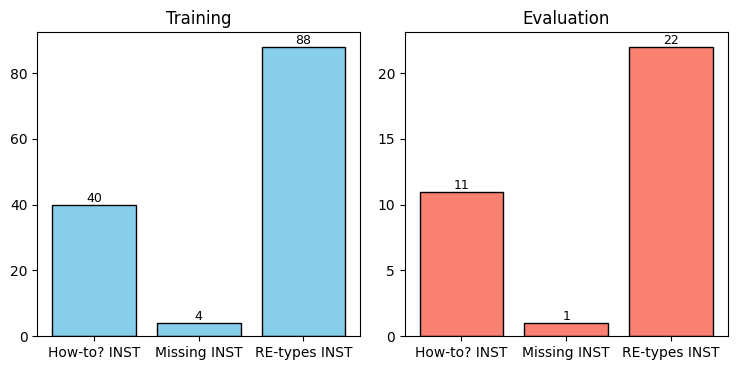

In [9]:
plt.figure(figsize=(7.5, 3.8))

# ploting the training set
plt.subplot(121)
bars_train = plt.bar(train_distro[0], train_distro[1], color='skyblue', edgecolor='black')
plt.xticks(rotation=0)
plt.title('Training')

for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=9)

# ploting evaluation set
plt.subplot(122)
bars_test = plt.bar(test_distro[0], test_distro[1], color = 'salmon', edgecolor='black')
plt.title('Evaluation')
plt.xticks(rotation=0)

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=9)

plt.tight_layout()
plt.savefig('./train_eval_set.pdf', bbox_inches = 'tight')
plt.show()

# Spider Chart: Evaluating Models per Task (BERT and FRUGAL scores)

In [10]:
# Loading the evaluation set

evaluation_set_path = './evaluation_set_for_nlp_metrics/models_prediction_dataset'
evaluation_set = datasets.load_from_disk(evaluation_set_path)
evaluation_set = evaluation_set.map(rename_tasks, batched = True)
evaluation_set.set_format(type = 'pandas')
evaluation_set_df = evaluation_set[:]
evaluation_set.reset_format()

In [11]:
evaluation_set

Dataset({
    features: ['REQID_ex', 'completion', 'query', 'class', 'task', 'text', 'label', 'mistral_ai_instruct_7b_chat_hf_preds', 'falcon_7b_base_preds', 'falcon_7b_instruct_preds', 'llama2_7b_chat_hf_preds', 'zephyr_7b_beta_preds', 'openai_compe_gpt4o_24_11_20', 'chatgpt4o_frugal_score', 'chatgpt4o_bleu_score', 'chatgpt4o_rougel_score', 'zephyr_frugal_score', 'zephyr_bleu_score', 'zephyr_rougel_score', 'mistralai_frugal_score', 'mistralai_bleu_score', 'mistralai_rougel_score', 'falcon_base_frugal_score', 'falcon_base_bleu_score', 'falcon_base_rougel_score', 'falcon_frugal_score', 'falcon_bleu_score', 'falcon_rougel_score', 'llama_frugal_score', 'llama_bleu_score', 'llama_rougel_score', 'renamed_tasks'],
    num_rows: 34
})

In [12]:
# isolating columns that contain scores with respect to each score

def filter_labels(labels, keyword):
    return [l for l in labels if keyword in l]

cols = evaluation_set.column_names

frugal_labels = filter_labels(cols, "frugal")
rougel_labels = filter_labels(cols, "rougel")
bleu_labels = filter_labels(cols, "bleu")

In [13]:
# converting to % and rounding them up

frugal_stats = evaluation_set_df.groupby(by = 'renamed_tasks')[frugal_labels].mean() * 100
frugal_stats = frugal_stats.applymap(lambda x: np.round(x, 2)).astype(float)

bleu_stats = evaluation_set_df.groupby(by = 'renamed_tasks')[bleu_labels].mean()
bleu_stats = bleu_stats.applymap(lambda x: np.round(x, 2)).astype(float)

rougel_stats = evaluation_set_df.groupby(by = 'renamed_tasks')[rougel_labels].mean() * 100
rougel_stats = rougel_stats.applymap(lambda x: np.round(x, 2)).astype(float)

frugal_stats = frugal_stats.T.iloc[1:] # excluding chatgpt-4o .iloc[1:]
bleu_stats = bleu_stats.T.iloc[1:] # excluding chatgpt-4o .iloc[1:]
rougel_stats = rougel_stats.T.iloc[1:] # excluding chatgpt-4o .iloc[1:]

In [14]:
frugal_stats

renamed_tasks,How-to? INST,Missing INST,RE-types INST
zephyr_frugal_score,89.62,86.99,92.19
mistralai_frugal_score,87.38,87.90,89.57
falcon_base_frugal_score,87.12,85.63,89.41
falcon_frugal_score,86.69,85.64,89.68
llama_frugal_score,86.48,86.80,89.01


In [15]:
bleu_stats

renamed_tasks,How-to? INST,Missing INST,RE-types INST
zephyr_bleu_score,12.26,12.26,12.26
mistralai_bleu_score,3.17,3.17,3.17
falcon_base_bleu_score,2.26,2.26,2.26
falcon_bleu_score,3.05,3.05,3.05
llama_bleu_score,2.35,2.35,2.35


In [16]:
rougel_stats

renamed_tasks,How-to? INST,Missing INST,RE-types INST
zephyr_rougel_score,36.86,36.86,36.86
mistralai_rougel_score,19.72,19.72,19.72
falcon_base_rougel_score,19.87,19.87,19.87
falcon_rougel_score,23.63,23.63,23.63
llama_rougel_score,19.02,19.02,19.02


In [17]:
label_mapper = {
    # 'chatgpt4o_frugal_score': 'ChatGPT-4o',
    # 'chatgpt4o_bleu_score': 'ChatGPT-4o',
    # 'chatgpt4o_rougel_score': 'ChatGPT-4o',
    'zephyr_bleu_score': 'Zephyr-7b-beta',
    'mistralai_bleu_score': 'Mistral-7B-Instruct-v0.2',
    'falcon_base_bleu_score': 'Falcon-7b',
    'falcon_bleu_score': 'Falcon-7b-instruct',
    'llama_bleu_score': 'Llama-2-7b-chat-hf',
    'zephyr_rougel_score': 'Zephyr-7b-beta',
    'mistralai_rougel_score': 'Mistral-7B-Instruct-v0.2',
    'falcon_base_rougel_score': 'Falcon-7b',
    'falcon_rougel_score': 'Falcon-7b-instruct',
    'llama_rougel_score': 'Llama-2-7b-chat-hf',
    'zephyr_frugal_score': 'Zephyr-7b-beta',
    'mistralai_frugal_score': 'Mistral-7B-Instruct-v0.2',
    'falcon_base_frugal_score': 'Falcon-7b',
    'falcon_frugal_score': 'Falcon-7b-instruct',
    'llama_frugal_score':  'Llama-2-7b-chat-hf'
}

In [18]:
frugal_labels = frugal_stats.columns.to_numpy()
frugal_values = frugal_stats.values
frugal_line_names = frugal_stats.index.to_numpy()

In [19]:
frugal_line_names

array(['zephyr_frugal_score', 'mistralai_frugal_score',
       'falcon_base_frugal_score', 'falcon_frugal_score',
       'llama_frugal_score'], dtype=object)

In [20]:
bleu_labels = bleu_stats.columns.to_numpy()
bleu_values = bleu_stats.values
bleu_line_names = bleu_stats.index.to_numpy()
bleu_labels

array(['How-to? INST', 'Missing INST', 'RE-types INST'], dtype=object)

In [21]:
bleu_line_names

array(['zephyr_bleu_score', 'mistralai_bleu_score',
       'falcon_base_bleu_score', 'falcon_bleu_score', 'llama_bleu_score'],
      dtype=object)

In [22]:
rougel_labels = rougel_stats.columns.to_numpy()
rougel_values = rougel_stats.values
rougel_line_names = rougel_stats.index.to_numpy()

In [23]:
rougel_line_names

array(['zephyr_rougel_score', 'mistralai_rougel_score',
       'falcon_base_rougel_score', 'falcon_rougel_score',
       'llama_rougel_score'], dtype=object)

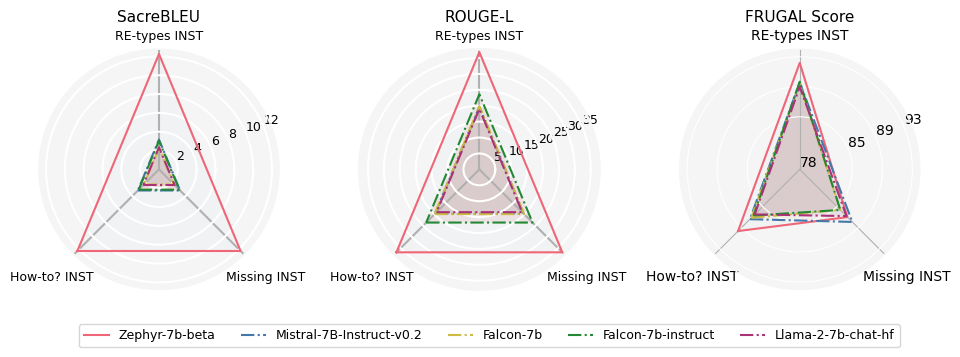

In [24]:
import matplotlib.colors as mcolors

# Old colur schema
# custom_colors = ['#E63946', '#F4A261', '#457B9D', '#A8DADC', '#D4A5A5', '#6A4C93']

custom_colors = [
    "#EE6677",  # safe red
    "#4477AA",  # safe blue
    "#CCBB44",  # safe yellow/orange
    "#228833",  # safe green
    "#AA3377",  # safe magenta
    "#66CCEE",  # safe cyan
]

custom_cmap = mcolors.ListedColormap(custom_colors)
line_colors = custom_colors

title_plot_1 = 'SacreBLEU'
labels_plot_1 = bleu_labels
values_plot_1 = bleu_values
line_names_plot_1 = [label_mapper[model_name] for model_name in bleu_line_names]


title_plot_2 = 'ROUGE-L'
labels_plot_2 = rougel_labels
values_plot_2 = rougel_values
line_names_plot_2 = [label_mapper[model_name] for model_name in rougel_line_names]

title_plot_3 = 'FRUGAL Score'
labels_plot_3 = frugal_labels
values_plot_3 = frugal_values
line_names_plot_3 = [label_mapper[model_name] for model_name in frugal_line_names]


num_vars = len(labels_plot_1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.1), subplot_kw=dict(polar=True))

# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_degrees = [225, 315, 90]
angles = np.deg2rad(angles_degrees).tolist()

angles += angles[:1]

# Plot for the first subplot
ax1.set_title(title_plot_1, pad = 20, fontsize = 11)
ax1.set_facecolor('whitesmoke') 
# ax1.set_ylim(10, 40)
# ax1.set_yticks([5, 10, 15, 20, 30, 35, 40])

line_styles = ['-', '-.', '-.', '-.', '-.']  
for i, val in enumerate(values_plot_1):
    val_closed = np.append(val, val[0])
    ax1.plot(angles, val_closed, linewidth = 1.5, linestyle = line_styles[i % len(line_styles)], label = line_names_plot_1[i], color = line_colors[i])
    ax1.fill(angles, val_closed, alpha = 0.02 * (i+1))


label_angles_1 = np.linspace(0, 2 * np.pi, len(labels_plot_1), endpoint = False).tolist()
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(labels_plot_1, rotation = 0, ha = 'center') 


ax1.spines['polar'].set_color('whitesmoke')
ax1.spines['polar'].set_linewidth(1)
ax1.yaxis.grid(True, color='white')

ax1.tick_params(colors= 'black', width = 50, labelsize = 9, grid_linewidth = 1.5, grid_linestyle = '-') 

ticks = ax1.get_xticklabels()
paddings = [-0.1, -0.1, 0.05] 
for tick, pad in zip(ticks, paddings):
    tick.set_position((tick.get_position()[0], pad))
    
    
# Plot for the second subplot
ax2.set_title(title_plot_2, pad = 20, fontsize= 11)
ax2.set_facecolor('whitesmoke')  
# ax2.set_ylim(2, 14)
# ax2.set_yticks([2, 5, 8, 11, 14])

for i, val in enumerate(values_plot_2):
    val_closed = np.append(val, val[0])
    ax2.plot(angles, val_closed, linewidth = 1.5, linestyle = line_styles[i % len(line_styles)], label=line_names_plot_2[i], color=line_colors[i])
    ax2.fill(angles, val_closed, alpha=0.02 * (i+1))


label_angles_2 = np.linspace(0, 2 * np.pi, len(labels_plot_2), endpoint = False).tolist()
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(labels_plot_2, rotation = 0, ha = 'center')  

    
ax2.spines['polar'].set_color('whitesmoke')
ax2.spines['polar'].set_linewidth(2)
ax2.yaxis.grid(True, color = 'white')

ax2.tick_params(colors= 'black', width = 50, labelsize = 9, grid_linewidth = 1.5, grid_linestyle = '-')

ticks = ax2.get_xticklabels()
paddings = [-0.1, -0.1, 0.05] 
for tick, pad, rot in zip(ticks, paddings, angles):
    tick.set_position((tick.get_position()[0], pad))

    
# Plot for the third subplot
ax3.set_title(title_plot_3, pad = 20, fontsize = 11)
ax3.set_facecolor('whitesmoke') 
ax3.set_ylim(78, 94)  
ax3.set_yticks([78, 85, 89, 93]) 

line_styles = ['-', '-.', '-.', '-.', '-.']  
for i, val in enumerate(values_plot_3):
    val_closed = np.append(val, val[0])
    ax3.plot(angles, val_closed, linewidth = 1.5, linestyle = line_styles[i % len(line_styles)], label = line_names_plot_3[i], color = line_colors[i])
    ax3.fill(angles, val_closed, alpha=0.02 * (i+1))


label_angles_3 = np.linspace(0, 2 * np.pi, len(labels_plot_1), endpoint = False).tolist()
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(labels_plot_3, rotation=0, ha='center') 


ax3.spines['polar'].set_color('whitesmoke')
ax3.spines['polar'].set_linewidth(1)
ax3.yaxis.grid(True, color='white')

ax1.tick_params(colors= 'black', width = 50, labelsize = 9, grid_linewidth = 1.5, grid_linestyle = '-') 

ticks = ax3.get_xticklabels()
paddings = [-0.1, -0.1, 0.05] 
for tick, pad in zip(ticks, paddings):
    tick.set_position((tick.get_position()[0], pad))
    
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center', bbox_to_anchor = (0.51, -0.1), ncol = 5, fontsize = 9, )

plt.subplots_adjust(wspace = -0.3) 
plt.tight_layout()
plt.savefig('./spider_chart.pdf', bbox_inches = 'tight')

plt.show()